# Mask out irrelevant sections of WT Gold trials

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import get_seg
from disp import set_plot

FPS = 30.03
DT = 1/FPS

NTR = 84
OFFSET = 276

MASK_PFX = 'data/simple/masks/mask_tr'

df = pd.read_csv('data/simple/w_song_f_behav.csv')
df

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,3.844019,-0.138725,0.841459,3.102308,3.663209,1.244644
1,0,1,0.033300,1,0,0,0,2.645045,0.217158,0.958827,1.644406,2.143699,1.633865
2,0,2,0.066600,1,0,0,0,2.817165,-0.170636,0.799927,0.591572,2.212304,1.895512
3,0,3,0.099900,1,0,0,0,4.238035,0.000825,0.455475,0.842094,3.535255,2.372842
4,0,4,0.133200,1,0,0,0,6.156643,0.280813,0.516347,1.218568,5.392901,2.986841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333241,83,11022,367.032967,0,0,0,1,-0.058612,0.000000,0.240739,0.721101,0.063511,0.234946
2333242,83,11023,367.066267,0,0,0,1,0.381769,0.000000,0.156364,0.000000,-0.366270,0.191376
2333243,83,11024,367.099567,0,0,0,1,0.196337,0.000000,0.482724,0.839733,-0.179289,0.481899
2333244,83,11025,367.132867,1,0,0,0,-0.403877,0.000000,0.139698,1.868385,0.410206,0.148874


In [2]:
# load down sampled data and plot atop original
ntr = np.max(df['ID']) + 1
dfs_tr = [df[df['ID'] == ctr] for ctr in range(ntr)]

In [3]:
SMOOTH = int(round(1/DT))
PAUSE_DUR = 30
IPAUSE_DUR = int(round(PAUSE_DUR/DT))

def make_mask(df_tr):
    
    t = df_tr['T']
    
    q = np.array(df_tr['Q'])
    
    ffv = df_tr['FFV']
    fls = df_tr['FLS']
    mtn = np.sqrt(ffv**2 + fls**2)
    
    mtn_smooth = smooth(mtn, SMOOTH)
   
    # make mask
    mask = np.ones(len(t), dtype=bool)
    
    # mask out all timepoints before first singing tp
    it_first_song = np.nonzero(~q)[0][0]
    mask[:it_first_song] = False
    
    # if any period longer than PAUSE_DUR w no singing, mask out all timepoints except first PAUSE_DUR seconds
    segs_q, bds_q = get_seg(q, min_gap=1)
    for it_start, it_end in bds_q:
        if (it_end - it_start) > IPAUSE_DUR:
            mask[it_start+IPAUSE_DUR:it_end] = False
            
    return mask

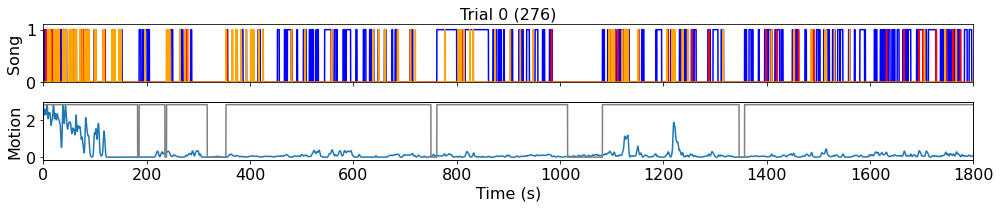

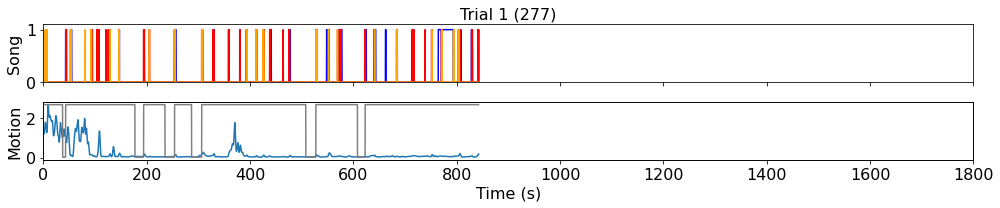

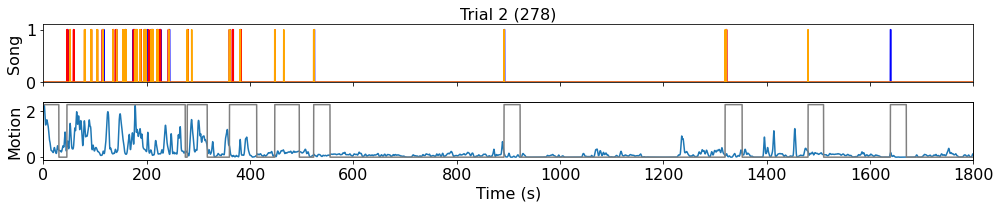

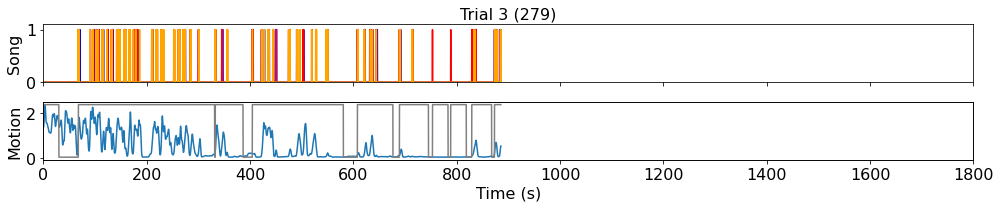

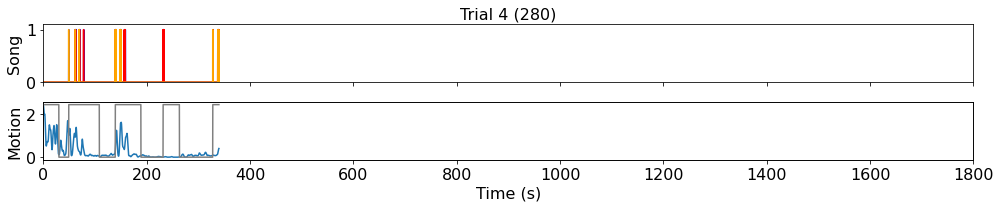

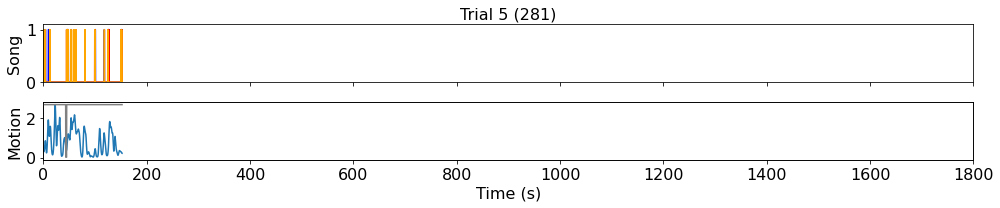

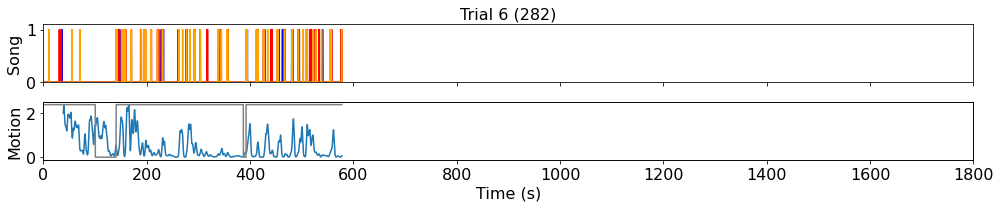

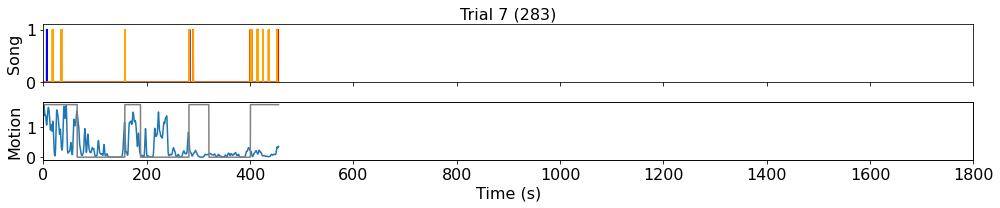

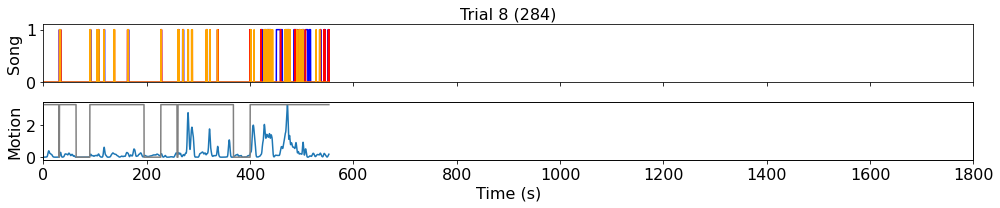

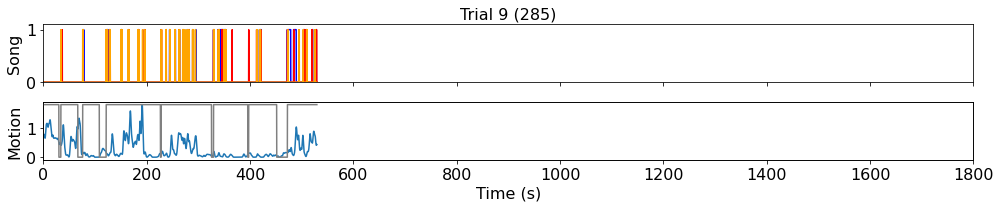

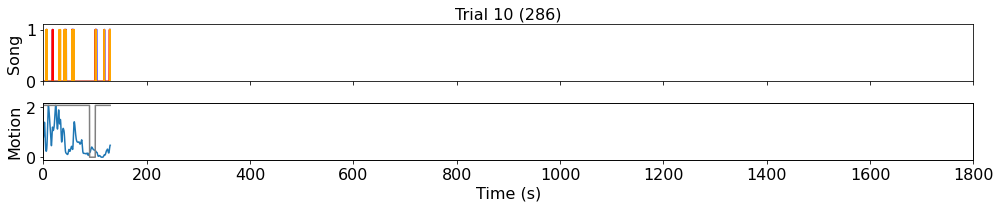

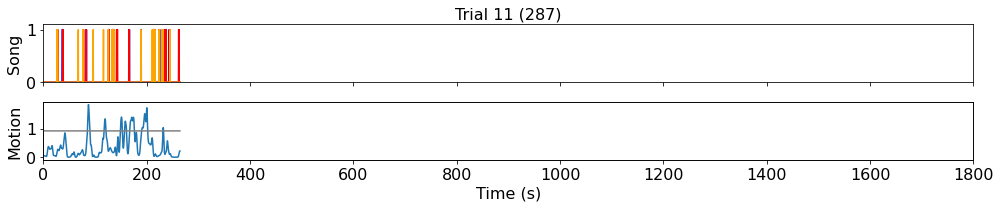

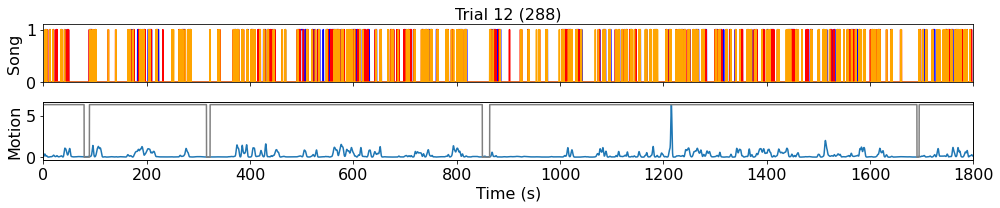

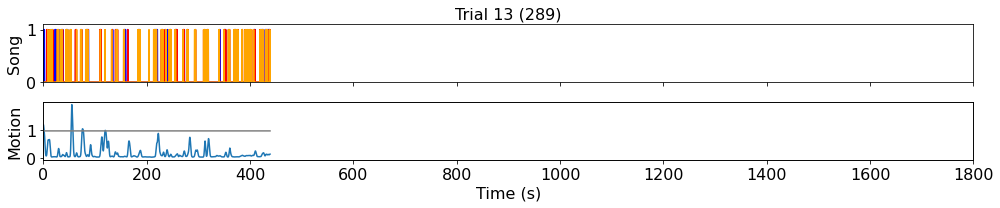

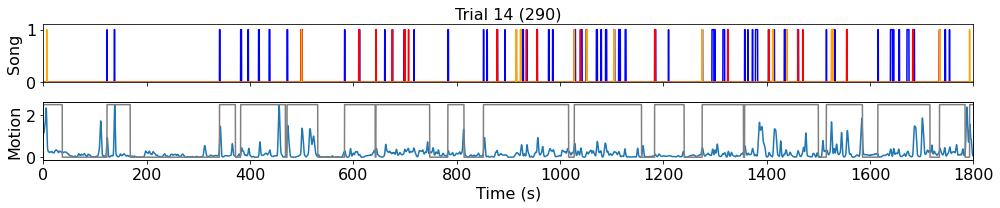

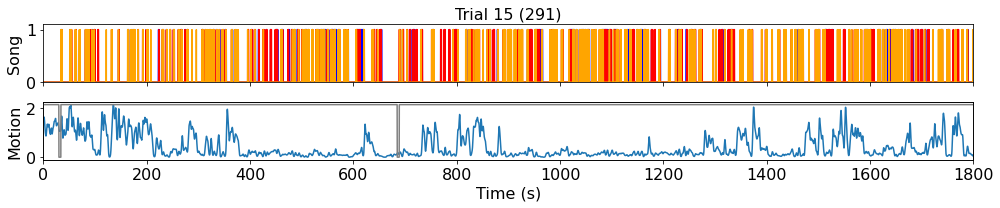

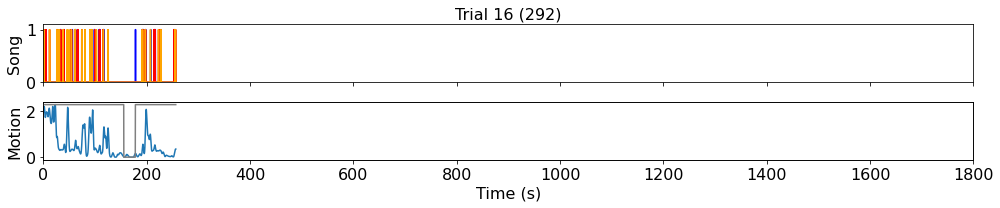

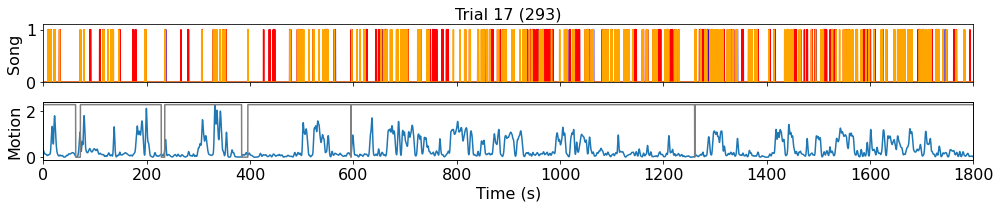

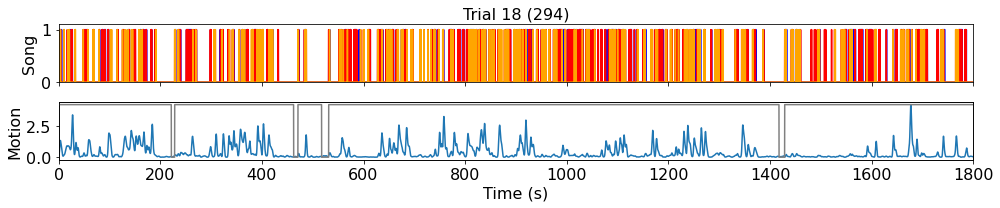

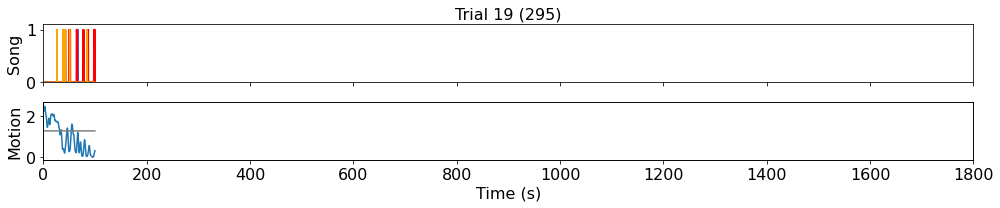

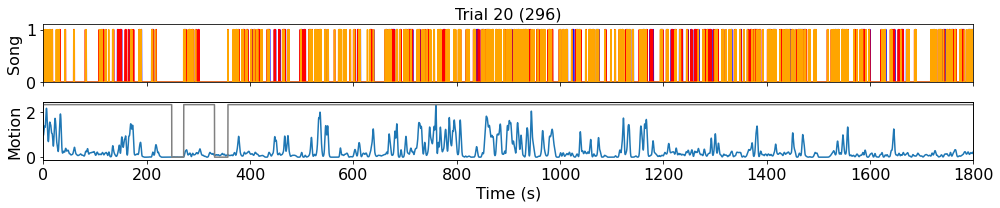

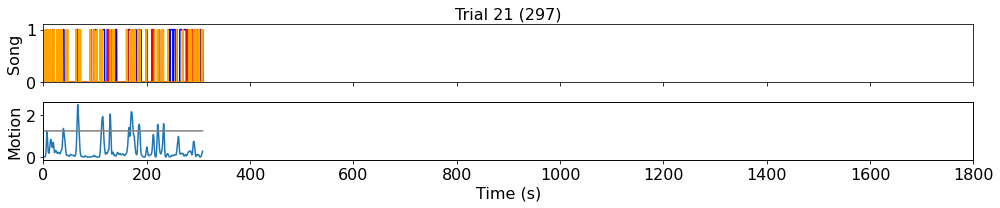

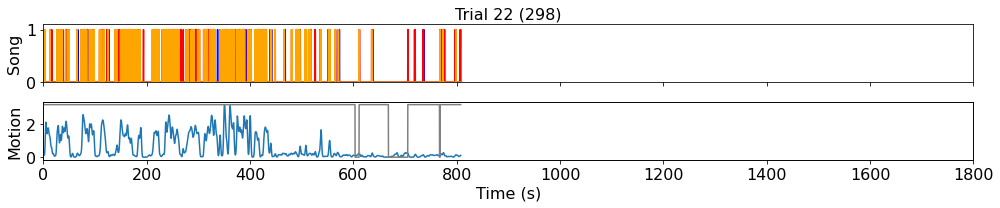

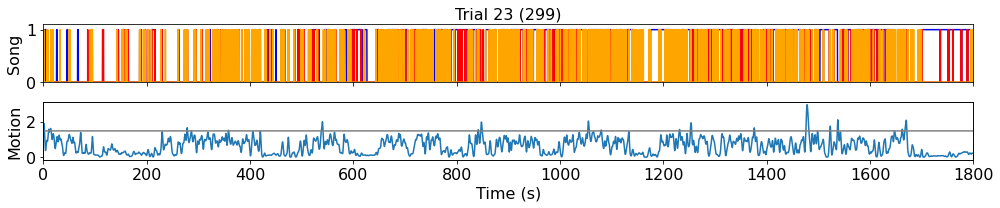

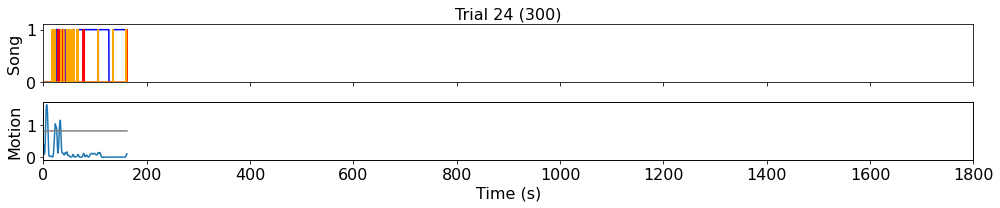

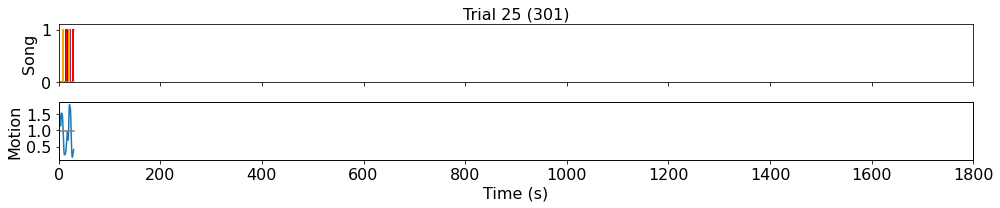

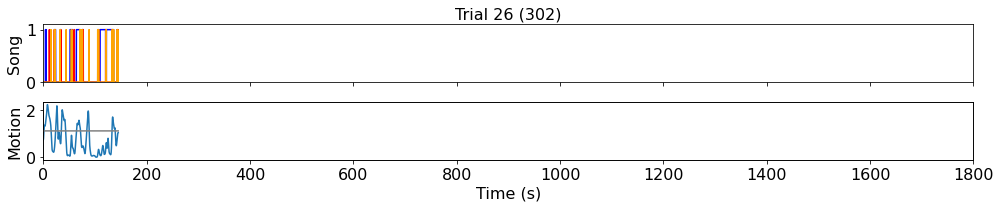

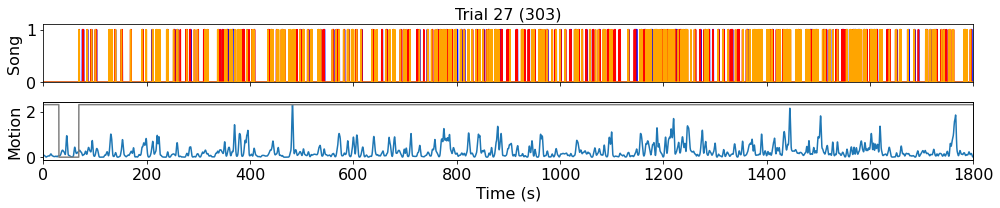

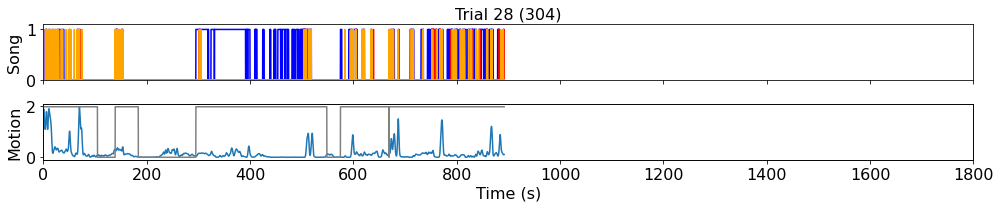

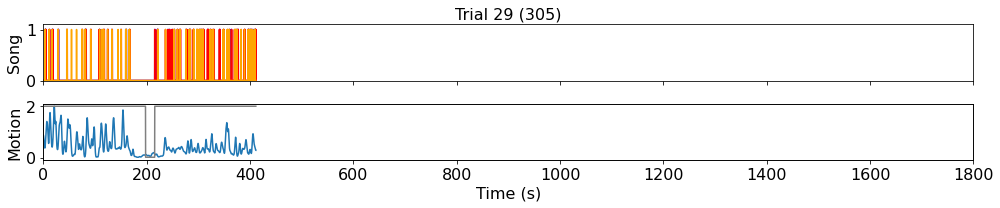

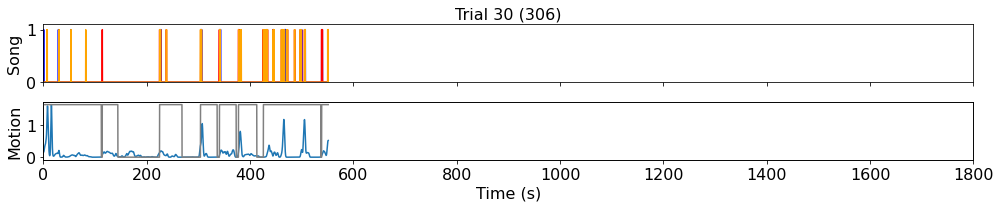

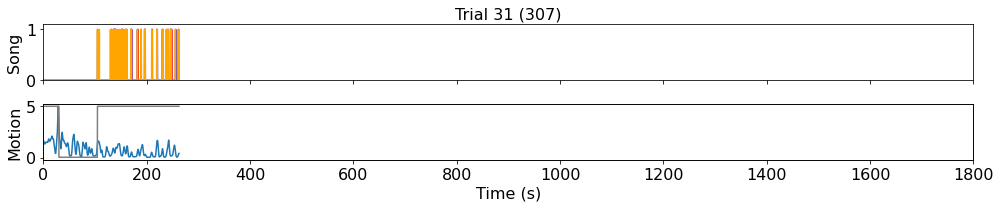

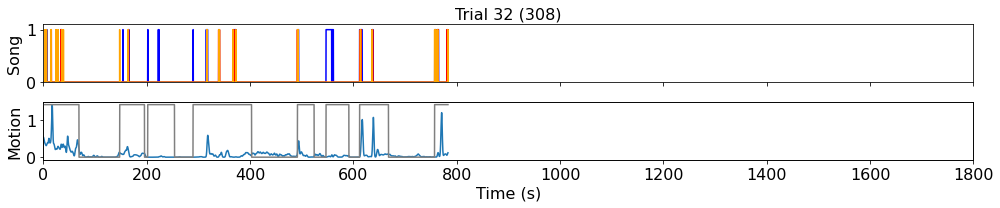

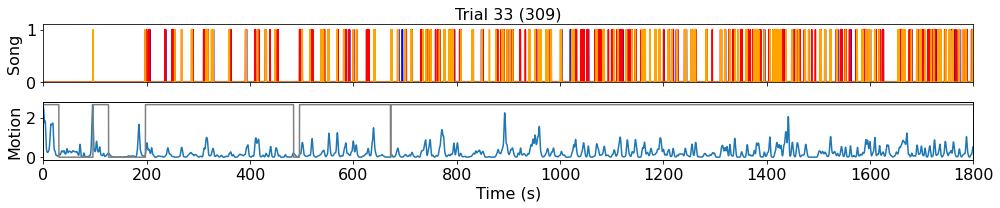

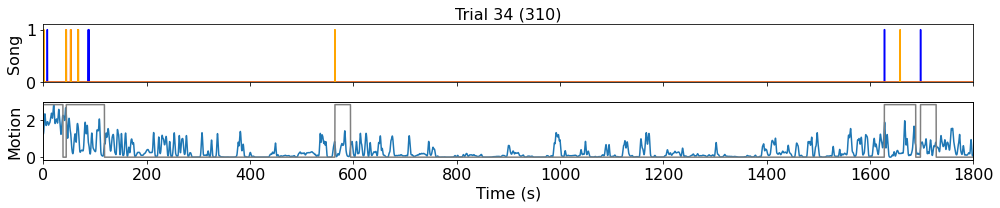

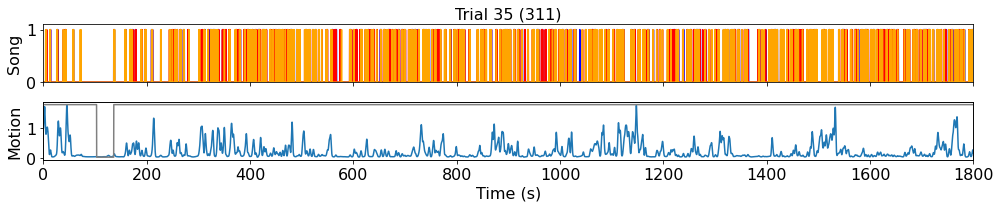

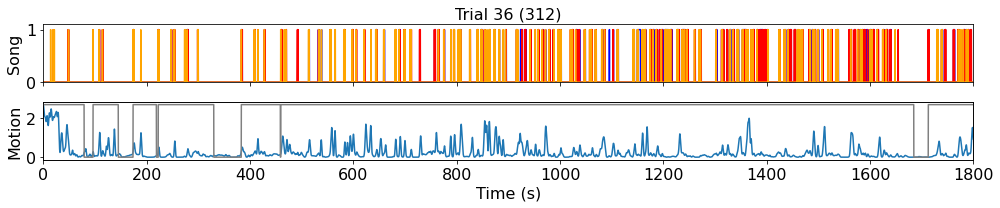

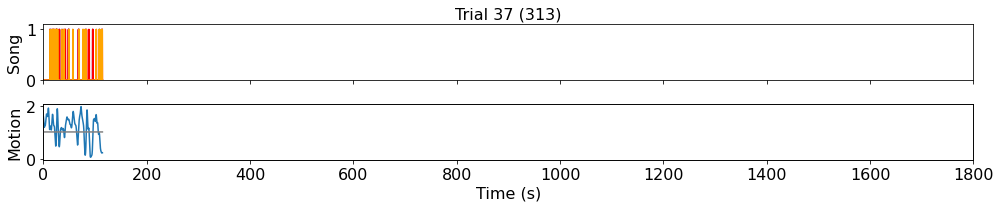

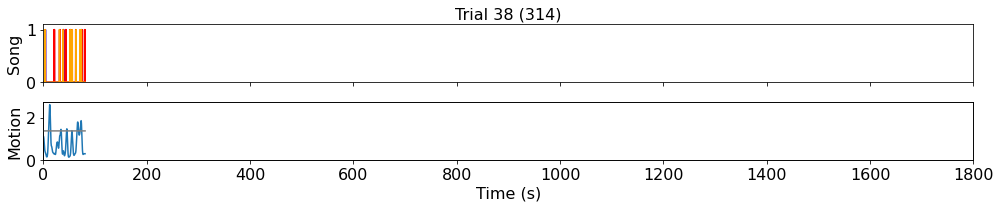

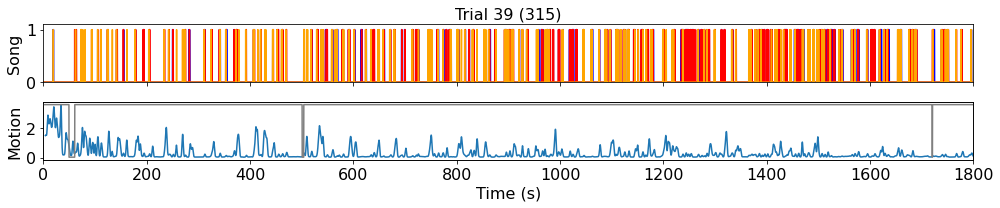

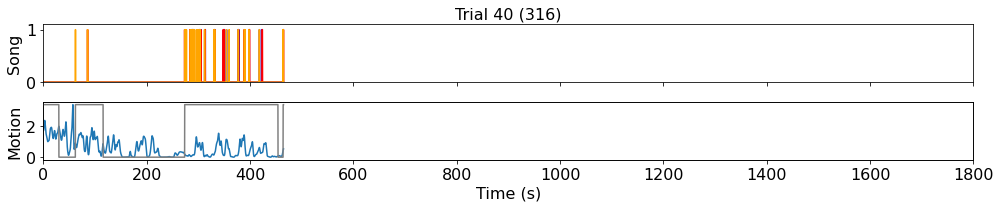

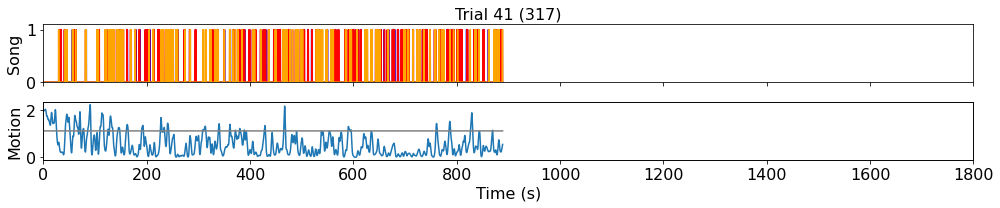

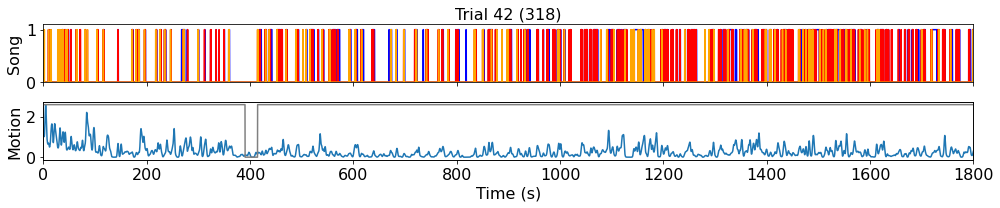

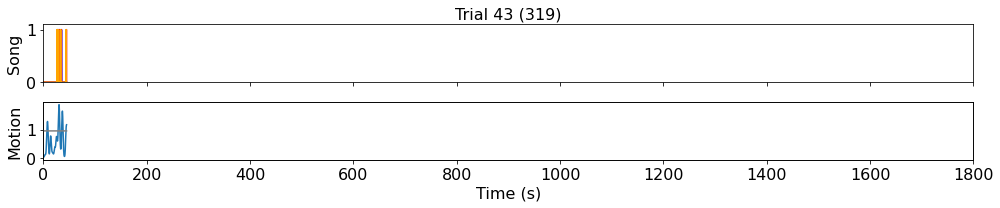

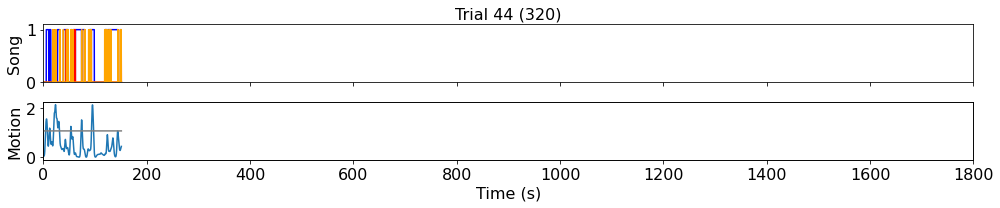

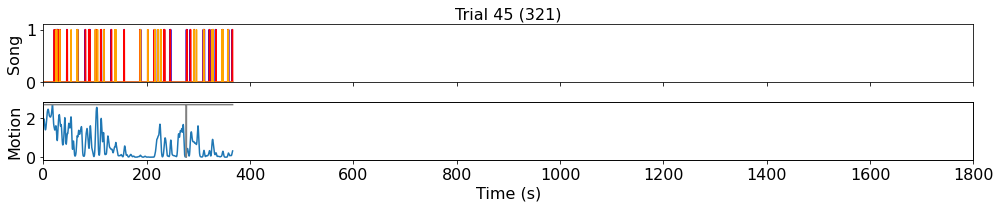

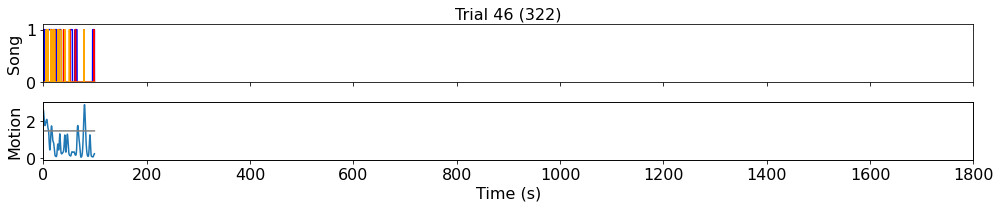

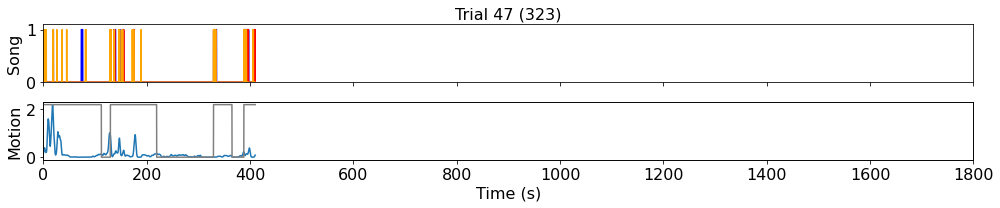

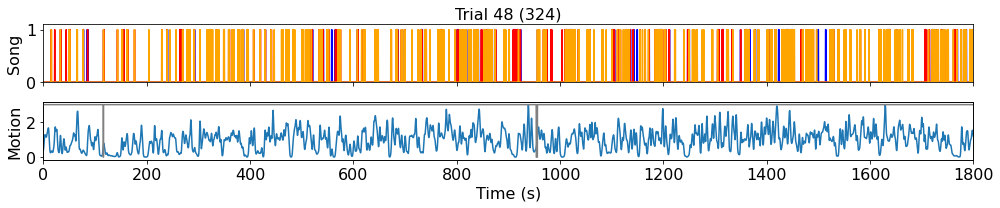

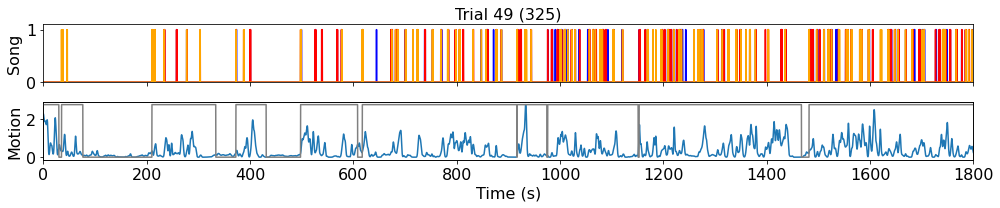

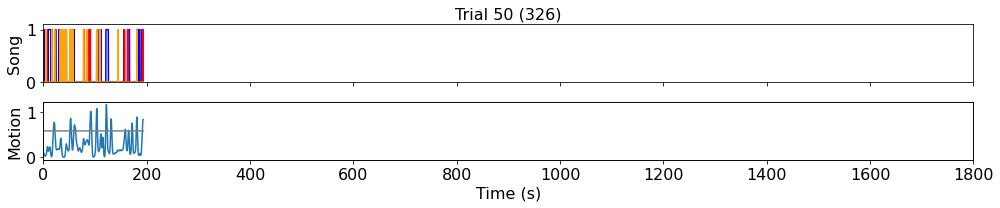

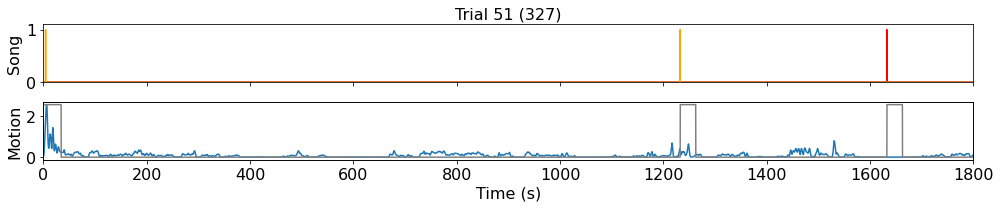

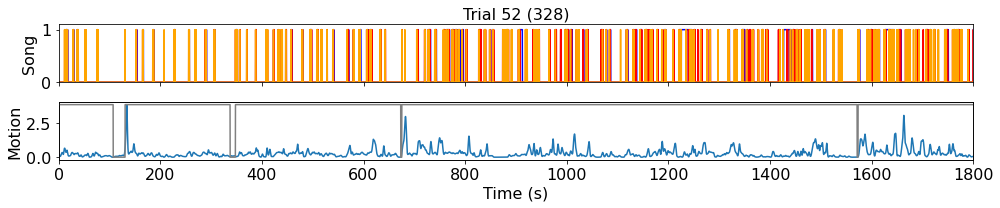

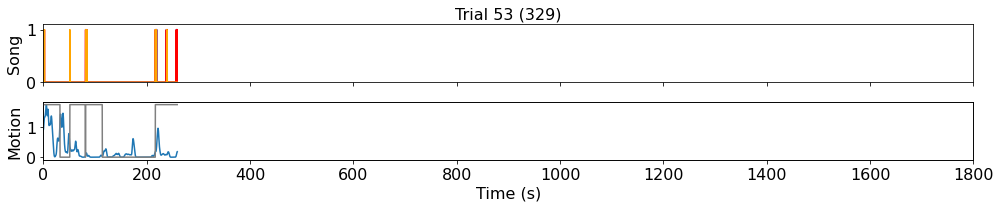

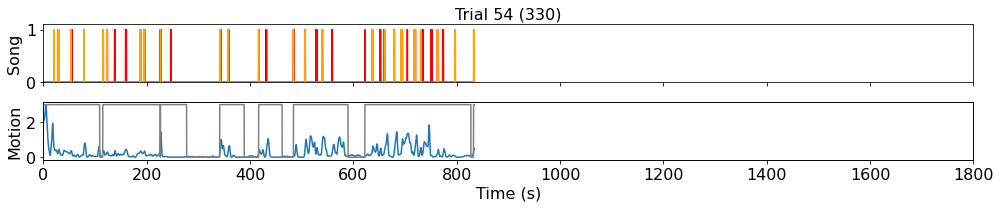

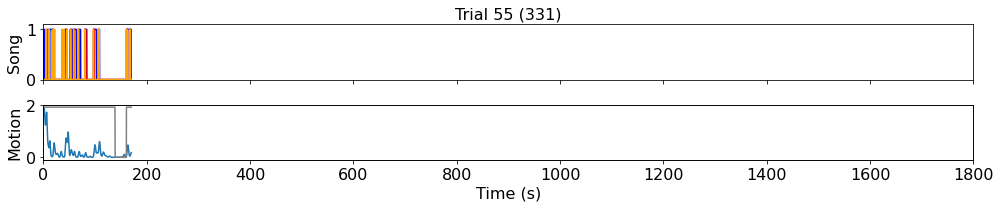

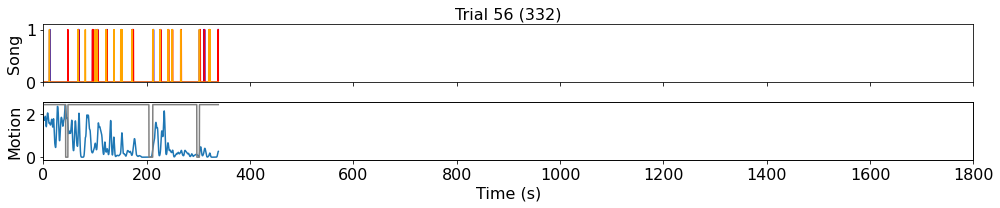

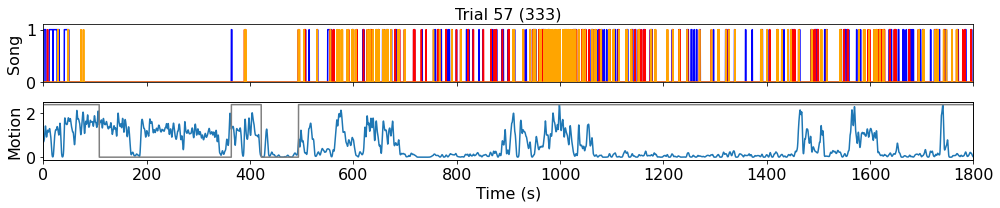

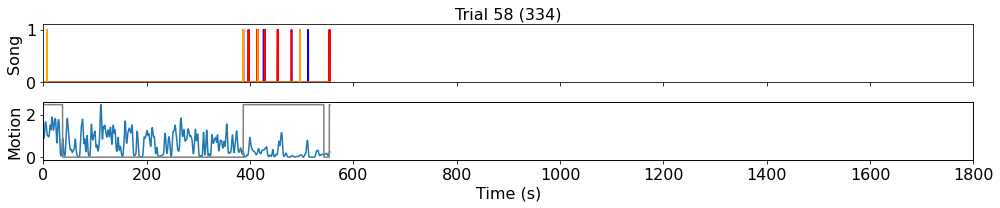

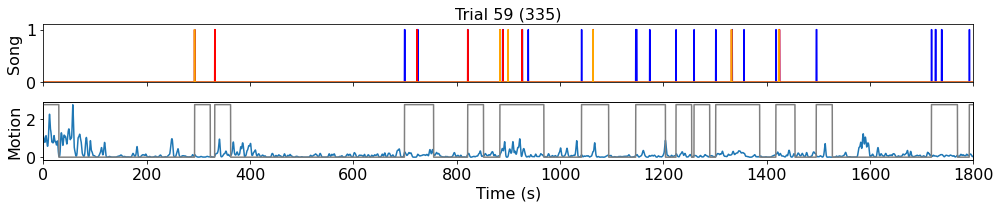

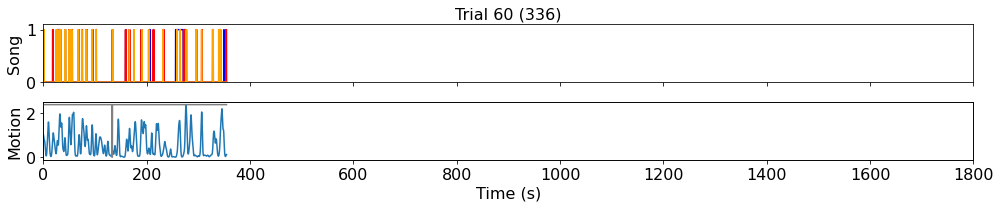

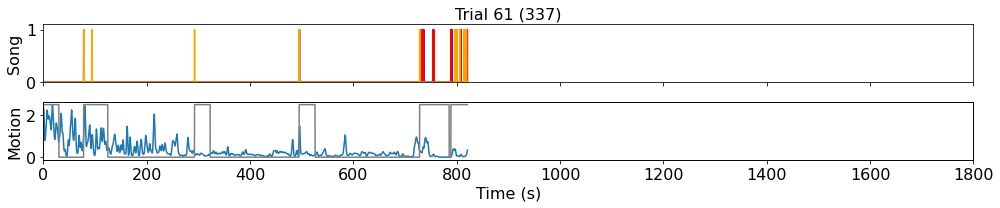

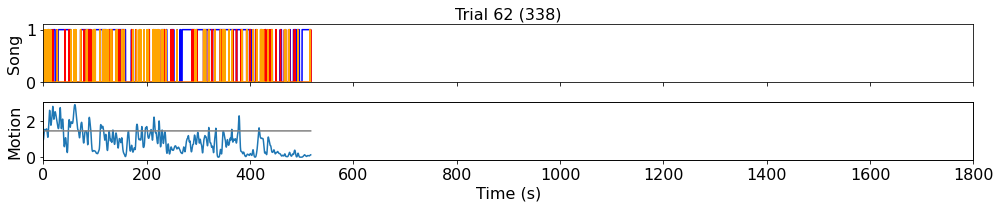

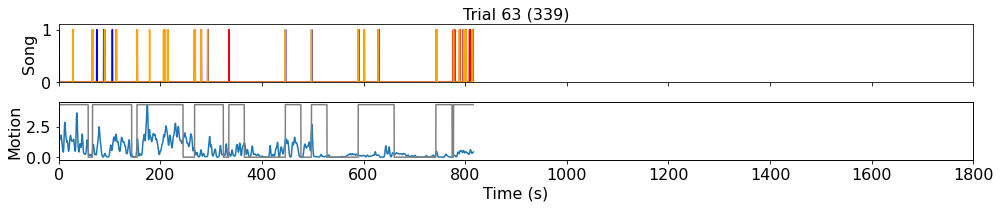

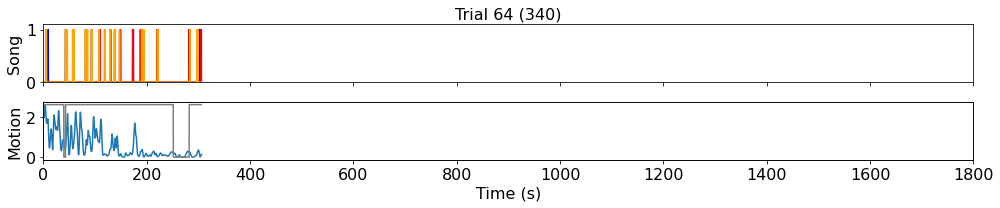

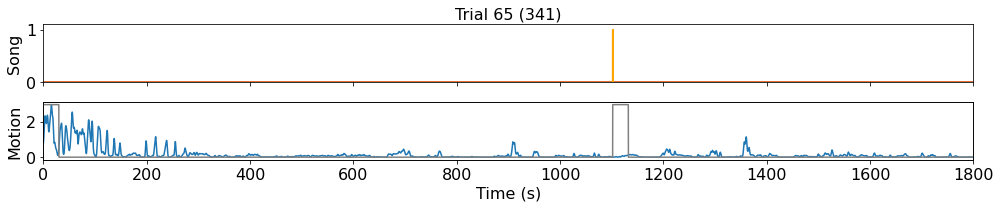

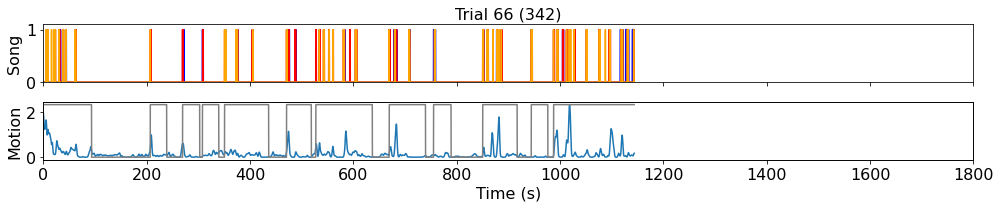

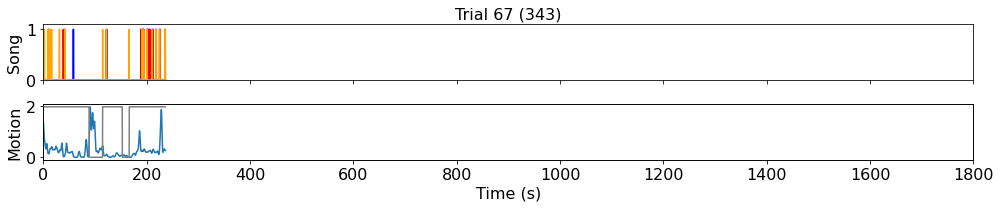

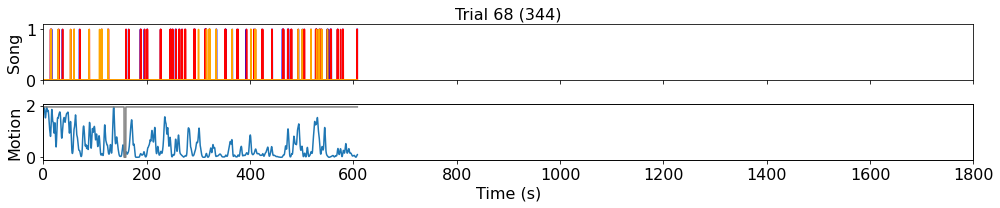

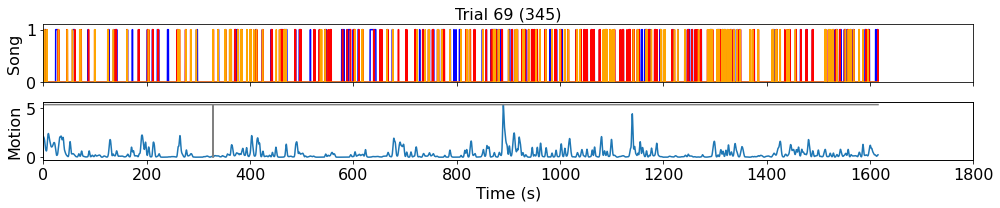

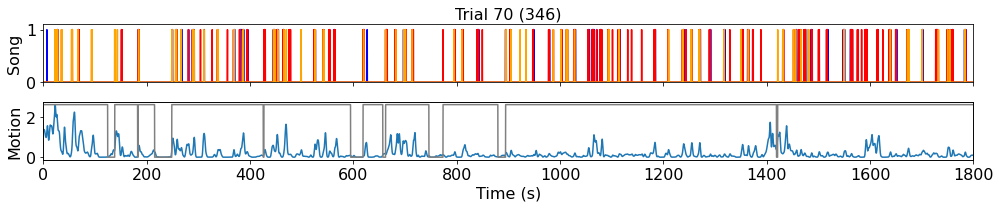

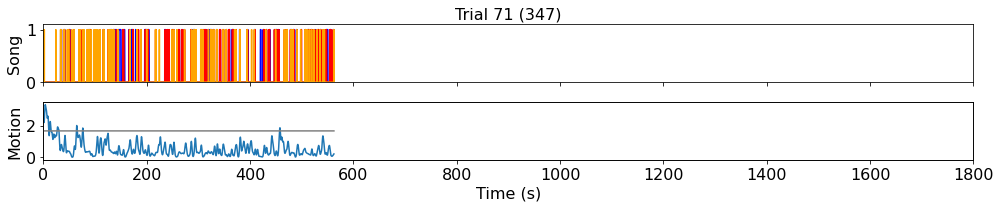

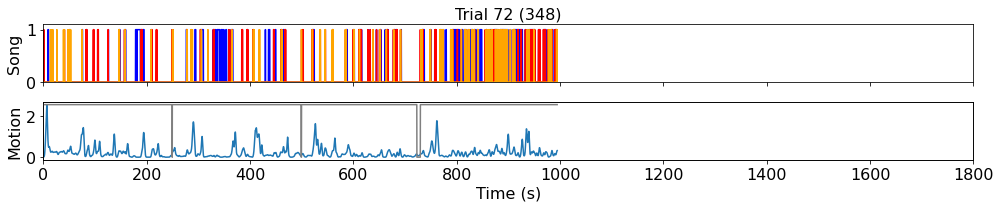

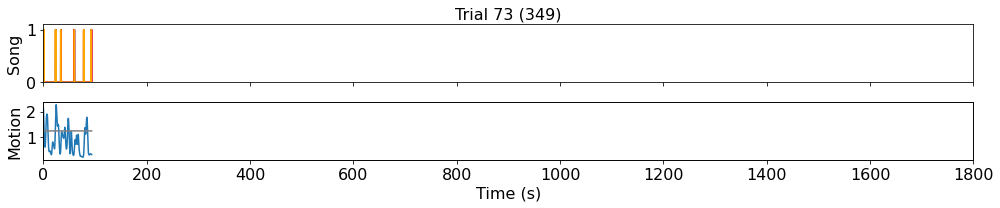

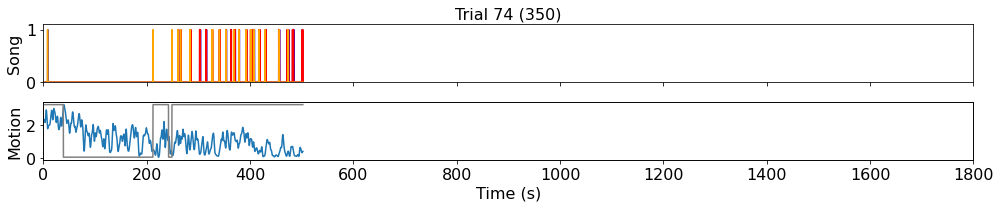

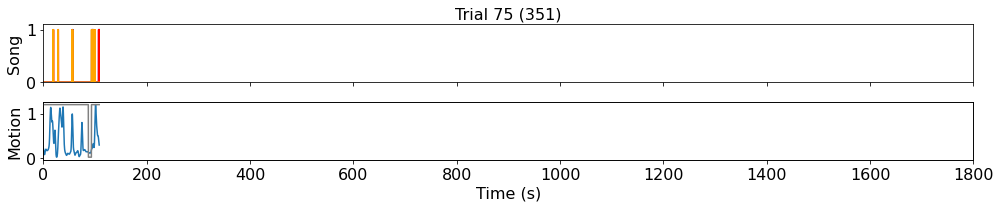

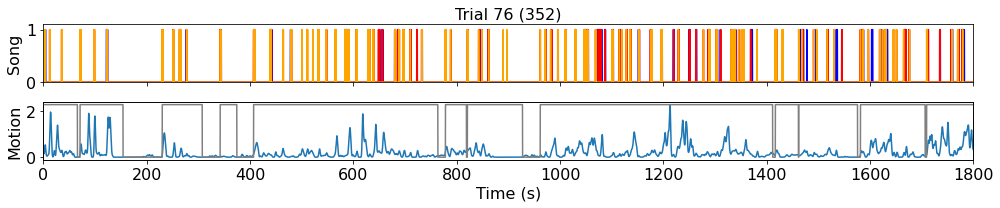

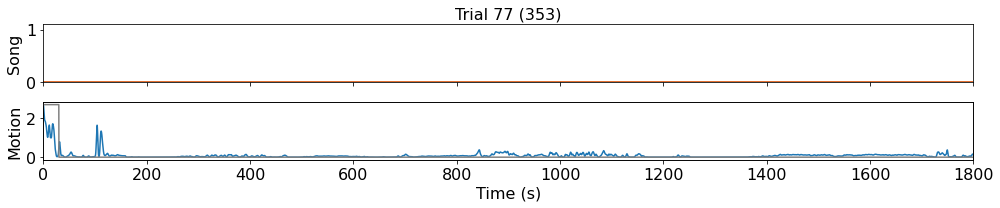

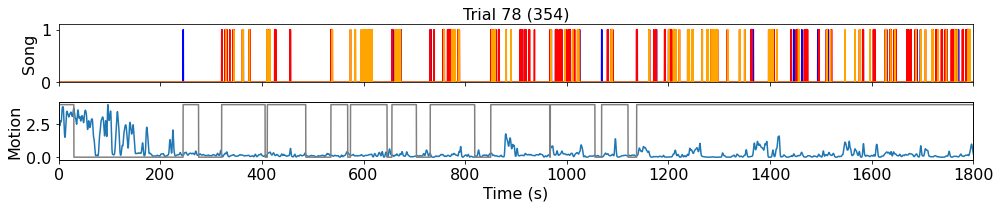

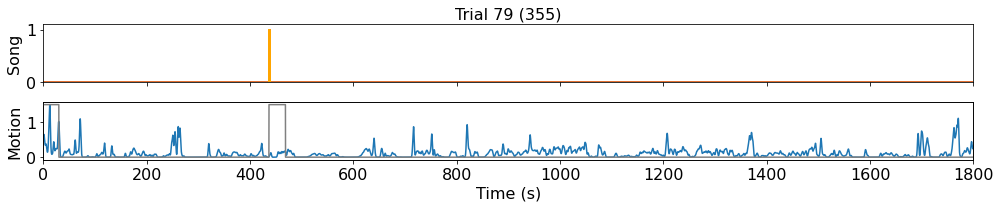

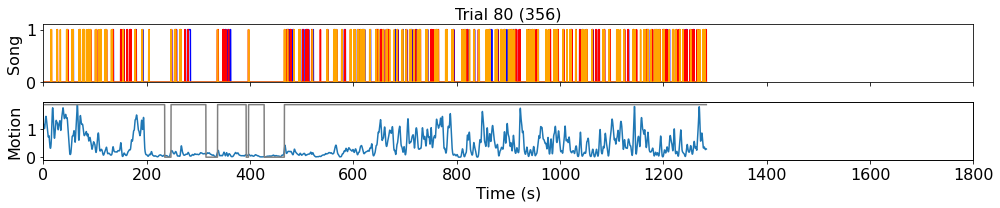

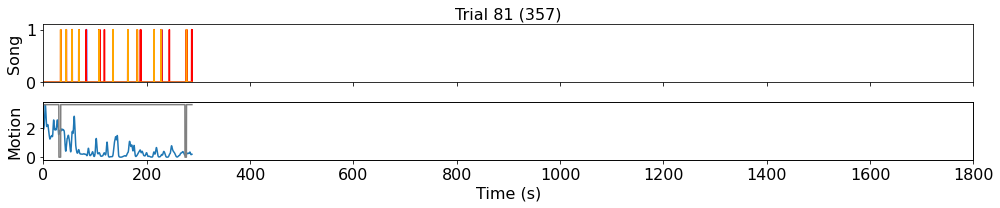

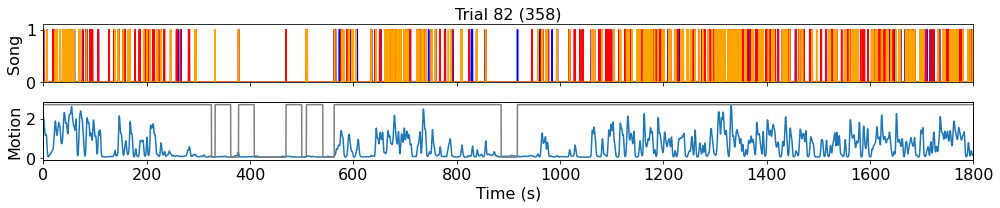

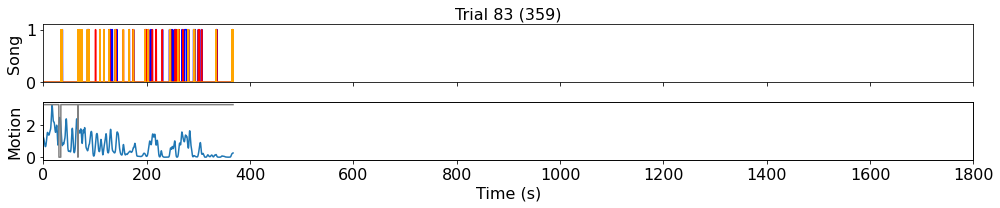

In [4]:
for ctr, df_tr in enumerate(dfs_tr):
    fig, axs = plt.subplots(2, 1, figsize=(14, 3), tight_layout=True, sharex=True)
    
    t = df_tr['T']
    q = df_tr['Q']
    s = df_tr['S']
    p = df_tr['P']
    f = df_tr['F']
    
    ffv = df_tr['FFV']
    fls = df_tr['FLS']
    
    mtn = np.sqrt(ffv**2 + fls**2)
    
    mask = make_mask(df_tr)
    
    itr = ctr+OFFSET
    
    # save mask
    np.save(f'{MASK_PFX}_{itr}.npy', np.array([{'mask': mask}]))
    mask = None
    
    # load mask
    mask = np.load(f'{MASK_PFX}_{itr}.npy', allow_pickle=True)[0]['mask']
    
    # song
    axs[0].plot(t, s, c='b')
    axs[0].plot(t, p, c='r')
    axs[0].plot(t, f, c='orange')
    set_plot(axs[0], y_lim=(0, 1.1), y_label='Song', title=f'Trial {ctr} ({itr})', font_size=16)
    
    # motion
    axs[1].plot(t, smooth(mtn, SMOOTH))
    set_plot(axs[1], x_lim=(0, 1800), x_label='Time (s)', y_label='Motion', font_size=16)
    
    ax_twin = axs[1].twinx()
    ax_twin.plot(t, mask, c='gray')
    ax_twin.yaxis.set_visible(False)